## Satellite image segmentation

In [130]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time

In [131]:
import mxnet as mx
import mxnet.ndarray as nd
import mxnet.gluon as gluon
import mxnet.gluon.nn as nn

from mxnet.gluon.data import Dataset, DataLoader
from mxnet.gluon.loss import Loss
from mxnet import image

### Data preparation

In [132]:
from skimage.io import imsave, imread
from datetime import datetime
import collections

In [133]:
geopedia_layers = {'tulip_field_2016':'ttl1904', 'tulip_field_2017':'ttl1905'}

In [134]:
class ImageWithMaskDataset(Dataset):
    """
    A dataset for loading images (with masks).
    Based on: mxnet.incubator.apache.org/tutorials/python/data_augmentation_with_masks.html
    
    Parameters
    ----------
    root : str
        Path to root directory.
    imgdir: str
        Path to folder containing the images, relative to root
    maskdir: str 
        Path to folder containing the masks/ground truth, relative to root
    transform : callable, default None
        A function that takes data and label and transforms them:
    ::
        transform = lambda data, label: (data.astype(np.float32)/255, label)
    """
    def __init__(self, imgdir, maskdir, transform=None):
        self._imgdir = os.path.expanduser(imgdir)
        self._maskdir = os.path.expanduser(maskdir)
        self._transform = transform
        self.imgdir = imgdir
        self._exts = ['.png']
        self._list_images(self._imgdir)

    def _list_images(self, root):
        images = collections.defaultdict(dict)
        for filename in sorted(os.listdir(root)):
            name, ext = os.path.splitext(filename)
            mask_flag = "geopedia" in name
            if ext.lower() not in self._exts:
                continue
            if not mask_flag:
                patch_id = filename.split('_')[1]
                year = datetime.strptime(filename.split('_')[3], "%Y%m%d-%H%M%S").year
                mask_fn = 'tulip_{}_geopedia_{}.png'.format(patch_id, geopedia_layers['tulip_field_{}'.format(year)])
                images[name]["base"] = filename
                images[name]["mask"] = mask_fn
        self._image_list = list(images.values())

    def __getitem__(self, idx):
        assert 'base' in self._image_list[idx], "Couldn't find base image for: " + image_list[idx]["mask"]
        base_filepath = os.path.join(self._imgdir, self._image_list[idx]["base"])
        base = mx.image.imread(base_filepath)
        assert 'mask' in self._image_list[idx], "Couldn't find mask image for: " + image_list[idx]["base"]
        mask_filepath = os.path.join(self._maskdir, self._image_list[idx]["mask"])
        mask = mx.image.imread(mask_filepath, flag=0)
        if self._transform is not None:
            return self._transform(base, mask)
        else:
            return base, mask

    def __len__(self):
        return len(self._image_list)

Image transformations for data augmentation. At the moment, data augmentation will happen offline before the training, so we will only use the transforms to reorder the channels, change data type, etc. Leaving the rest of them here in case this design choice changes in the future.

In [135]:
def positional_augmentation(joint):
    # Random crop
    crop_height = img_height
    crop_width  = img_width
    aug = mx.image.RandomCropAug(size=(crop_width, crop_height)) # Watch out: weight before height in size param!
    aug_joint = aug(joint)
    # Horizontal flip (50% probability)
#     aug = mx.image.HorizontalFlipAug(0.5)
#     aug_joint = aug(aug_joint)
    return aug_joint


def color_augmentation(base):
    # Only applied to the base image, and not the mask layers.
    aug = mx.image.ColorJitterAug(brightness=0.2, contrast=0.2, saturation=0)
    aug_base = aug(base)
    return aug_base


def joint_transform(base, mask):
    ### Convert types
    base = base.astype('float32')/255
    mask = mask.astype('float32')/255
    
    ### Join
    # Concatinate on channels dim, to obtain an 6 channel image
    # (3 channels for the base image, plus 3 channels for the mask)
    base_channels = base.shape[2] # so we know where to split later on
    joint = mx.nd.concat(base, mask, dim=2)

    ### Augmentation Part 1: positional
    aug_joint = positional_augmentation(joint)
    
    ### Split
    aug_base = aug_joint[:, :, :base_channels]
    aug_mask = aug_joint[:, :, base_channels:]
    
    ### Augmentation Part 2: color
#     aug_base = color_augmentation(aug_base)
    
    # Convert mask to binary
    aug_mask = (aug_mask > 0.4).astype('float32')
    
    # Reshape the tensors so the order is now (channels, w, h)
    aug_base =  mx.nd.transpose(aug_base, (2,0,1))
    aug_mask =  mx.nd.transpose(aug_mask, (2,0,1))
    
    return aug_base, aug_mask

###  U-Net

In [136]:
def conv_block(channels, kernel_size):
    out = nn.HybridSequential()
    out.add(
        nn.Conv2D(channels, kernel_size, padding=1, use_bias=False),
        nn.BatchNorm(),
        nn.Activation('relu')
    )
    return out

In [137]:
def down_block(channels):
    out = nn.HybridSequential()
    out.add(
        conv_block(channels, 3),
        conv_block(channels, 3)
    )
    return out

In [138]:
class up_block(nn.HybridBlock):
    def __init__(self, channels, shrink=True, **kwargs):
        super(up_block, self).__init__(**kwargs)
        self.upsampler = nn.Conv2DTranspose(channels=channels, kernel_size=4, strides=2, 
                                            padding=1, use_bias=False)
        self.conv1 = conv_block(channels, 1)
        self.conv3_0 = conv_block(channels, 3)
        if shrink:
            self.conv3_1 = conv_block(int(channels/2), 3)
        else:
            self.conv3_1 = conv_block(channels, 3)
    def hybrid_forward(self, F, x, s):
        x = self.upsampler(x)
        x = self.conv1(x)
        x = F.relu(x)
        x = F.Crop(*[x,s], center_crop=True)
        x = s + x
        x = self.conv3_0(x)
        x = self.conv3_1(x)
        return x

In [139]:
class Unet(nn.HybridBlock):
    def __init__(self, **kwargs):
        super(Unet, self).__init__(**kwargs)
        with self.name_scope():
            self.d0 = down_block(64)
            
            self.d1 = nn.HybridSequential()
            self.d1.add(nn.MaxPool2D(2,2,ceil_mode=True), down_block(128))
            
            self.d2 = nn.HybridSequential()
            self.d2.add(nn.MaxPool2D(2,2,ceil_mode=True), down_block(256))
            
            self.d3 = nn.HybridSequential()
            self.d3.add(nn.MaxPool2D(2,2,ceil_mode=True), down_block(512))
            
            self.d4 = nn.HybridSequential()
            self.d4.add(nn.MaxPool2D(2,2,ceil_mode=True), down_block(1024))
            
            self.u3 = up_block(512, shrink=True)
            self.u2 = up_block(256, shrink=True)
            self.u1 = up_block(128, shrink=True)
            self.u0 = up_block(64, shrink=False)
            
            self.conv = nn.Conv2D(2,1)
            
    def hybrid_forward(self, F, x):
        x0 = self.d0(x)
        x1 = self.d1(x0)
        x2 = self.d2(x1)
        x3 = self.d3(x2)
        x4 = self.d4(x3)

        y3 = self.u3(x4,x3)
        y2 = self.u2(y3,x2)
        y1 = self.u1(y2,x1)
        y0 = self.u0(y1,x0)
        
        out = F.softmax(self.conv(y0), axis=1)
        
        return out

### Loss

The IoU metric tends to have a "squaring" effect on the errors relative to the Dice score (aka F score). So the F score tends to measure something closer to average performance, while the IoU score measures something closer to the worst case performance.

https://stats.stackexchange.com/questions/273537/f1-dice-score-vs-iou

As we are not very confident on the quality of the training data/ground truth, lets go for the Dice coeff

In [141]:
class DiceCoeffLoss(Loss):
    """
    Soft dice coefficient loss.
    Based on https://github.com/Lasagne/Recipes/issues/99
    Input:
       pred: (batch size, c, w, h) network output, must sum to 1 over c channel (such as after softmax)
       label:(batch size, c, w, h) one hot encoding of ground truth
       eps; smoothing factor to avoid division by zero
    :param eps: 
    Output:
        Loss tensor with shape (batch size) 
    """

    def __init__(self, eps=1e-7, _weight = None, _batch_axis= 0, **kwards):
        Loss.__init__(self, weight=_weight, batch_axis=_batch_axis, **kwards)
        self.eps = eps

    def hybrid_forward(self, F, label, pred):
#         assert label.shape[1] == 1, 'Incorrect dimensions for label: {}'.format(label.shape)
#         assert pred.shape[1]  == 1, 'Incorrect dimensions for prediction: {}'.format(pred.shape)
#         intersect = nd.sum((label * pred), axis=self.axis)
#         dice = -(2. * intersect + self.smooth)/(nd.sum(label, axis=self.axis) + nd.sum(pred, axis=self.axis) + self.smooth)
        
        # One-hot encode the label
        label = nd.concatenate([label != 1, label], axis=1)
        
        axes = tuple(range(2, len(pred.shape)))
        intersect = nd.sum(pred * label, axis=axes)
        denom = nd.sum(pred + label, axis=axes)
        return - (2. *intersect / (denom + self.eps)).mean(axis=1)

In [142]:
# Not in use right now, keeping it here in case it's useful in the future
# def iou(a, b):
#     i = nd.sum((a==1)*(b==1),axis=[2,3])
#     u = nd.sum(a,axis=[2,3]) + nd.sum(b, axis=[2,3]) - i
#     return (i+1)/(u+1)

### Evaluation metric

In [145]:
class DiceCoeffMetric(mx.metric.EvalMetric):
    """Stores a moving average of the dice coeff"""
    def __init__(self, axis=[2,3], smooth=1):
        super(DiceCoeffMetric, self).__init__('DiceCoeff')
        self.name = 'Dice coefficient'
        self.axis = axis
        self.smooth = smooth
        self.reset()

    def reset(self):
        """
        override reset behavior
        """
        self.num_inst = 0
        self.sum_metric = 0.0

    def update(self, label, pred):
        """
        Implementation of updating metrics
        """
        intersect = nd.sum((label * pred), axis=self.axis)
        dice = (2. * intersect + self.smooth)/(nd.sum(label, axis=self.axis) + nd.sum(pred, axis=self.axis) + self.smooth)
        self.sum_metric += nd.sum(dice, axis=0)
        self.num_inst += pred.shape[0]

        
    def get(self):
        """Get the current evaluation result.
        Override the default behavior

        Returns
        -------
        name : str
           Name of the metric.
        value : float
           Value of the evaluation.
        """
        value = (self.sum_metric / self.num_inst).asscalar() if self.num_inst != 0 else float('nan')
        return (self.name, value)


In [146]:
class IouMetric(mx.metric.EvalMetric):
    """Stores a moving average of the intersection over union metric"""
    def __init__(self, axis=[2,3], smooth=1):
        super(IouMetric, self).__init__('IoU')
        self.name = 'IoU'
        self.axis = axis
        self.smooth = smooth
        self.reset()

    def reset(self):
        """
        override reset behavior
        """
        self.num_inst = 0
        self.sum_metric = 0.0

    def update(self, label, pred):
        """
        Implementation of updating metrics
        """
        i = nd.sum((pred==1)*(label==1), axis=self.axis)
        u = nd.sum(pred, axis=self.axis) + nd.sum(label, axis=self.axis) - i
        iou = (i + self.smooth) / (u + self.smooth)
        self.sum_metric += nd.sum(iou, axis=0)
        self.num_inst += pred.shape[0]
        
    def get(self):
        """Get the current evaluation result.
        Override the default behavior

        Returns
        -------
        name : str
           Name of the metric.
        value : float
           Value of the evaluation.
        """
        value = (self.sum_metric / self.num_inst).asscalar() if self.num_inst != 0 else float('nan')
        return (self.name, value)

In [147]:
def metric_str(names, vals):
    return '{}={}'.format(names, vals)

### Training

In [148]:
def evaluate(data_iterator, net):
    metric = IouMetric()
    for data, label in data_iterator:
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        # data = color_normalize(data/255, mean, std)
        output = net(data)
        pred = nd.reshape(np.argmax(output, axis=1), (0, 1, img_width, img_height))
        # prediction = mx.nd.argmax(output, axis=1)
        metric.update(label, pred)
    return metric.get()[1]

In [149]:
def train_util(net, train_iter, val_iter, loss_fn,
               trainer, ctx, epochs, batch_size, checkpoint_dir, init_epoch=0):
    '''
    Function to train the neural network.
    
    PARAMS:
    - net: network to train
    - train_iter: gluon.data.DataLoader with the training data
    - validation_iter: "                      "  validation data
    - loss_fn: loss function to use for training
    - trainer: gluon.Trainer to use for training
    - ctx: context where we will operate (GPU or CPU)
    - epochs: number of epochs to train for
    - batch_size
    - checkpoint_dir: directory where checkpoints are saved every 100 batches
    - init_epoch: set to the initial epoch in case training is resumed from a previous execution
    '''
    os.makedirs(checkpoint_dir, exist_ok=True)
    res = {'train':[],'val':[]}
    for epoch in range(1 + init_epoch, epochs + init_epoch+1):
        metric = IouMetric()
        for i, (data, label) in enumerate(train_iter):
            st = time.time()
            # Ensure context            
            data = data.as_in_context(ctx)
            label = label.as_in_context(ctx)
            # Normalize images?
            # data = color_normalize(data/255, mean, std)
            
            with mx.autograd.record():
                output = net(data)
                loss = loss_fn(label, output)
                pred = nd.reshape(np.argmax(output, axis=1), (0, 1, img_width, img_height))
                
            loss.backward()
            trainer.step(data.shape[0], ignore_stale_grad=True)
            
            #  Keep a moving average of the losses
            metric.update(label, pred)
            names, vals = metric.get()
            if i%5 == 0:
                print('[Epoch %d Batch %d] speed: %f samples/s, training: %s'%(epoch, i, batch_size/(time.time()-st), metric_str(names, vals)))
                           
        net.save_params('%s/%d.params'%(checkpoint_dir, epoch))
        names, train_acc = metric.get()
        val_acc = evaluate(val_iter, net)
        res['train'].append(train_acc)
        res['val'].append(val_acc)
        print("Epoch %s | training_acc %s | val_acc %s " % (epoch, train_acc, val_acc))
        metric.reset()
        
    return res

### Run

In [150]:
ctx = mx.gpu(0)

In [151]:
batch_size = 8
img_width  = 256
img_height = 256

Training images can be found in the output folder of our Augmentor, train/, along with their corresponding masks. Validation images are in val/ but their masks are in masks/ . See prepare_data.ipynb for reference.

In [152]:
train_dir = '../data/tulips/bloom/train/'
val_dir   = '../data/tulips/bloom/val/'
mask_dir  = '../data/tulips/bloom/masks/'

Create train and validation DataLoaders from our Datasets. No transformations are applied because data augmentation takes place in a previous offline step.

In [153]:
train_ds = ImageWithMaskDataset(train_dir, train_dir, transform=joint_transform)
train_iter = gluon.data.DataLoader(train_ds, batch_size)

In [154]:
val_ds  = ImageWithMaskDataset(val_dir, mask_dir, transform=joint_transform)
val_iter= gluon.data.DataLoader(val_ds, batch_size)

The two cells below are only used to visually check if our ImageWithMaskDataset's are working.

In [155]:
def plot_mx_arrays(arrays):
    """
    Array expected to be height x width x 3 (channels), and values are floats between 0 and 255.
    """
    plt.subplots(figsize=(14, 8))
    for idx, array in enumerate(arrays):
        array = mx.nd.transpose(array, (1, 2, 0))
        if array.shape[2] != 3:
            array = nd.reshape(array, (array.shape[0],array.shape[0]))
        plt.subplot(1, 2, idx+1)
        plt.imshow(array.asnumpy())

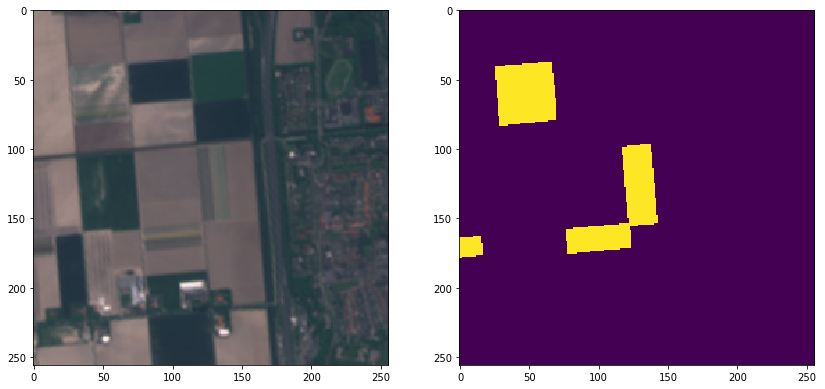

In [156]:
sample = train_ds.__getitem__(333)
sample_base = sample[0].astype('float32')
sample_mask = sample[1].astype('float32')

plot_mx_arrays([sample_base, sample_mask])

Instantiate a U-Net and train it

In [157]:
net = Unet()

In [158]:
net.collect_params().initialize(mx.init.Xavier(), ctx=ctx)
net.hybridize()

In [159]:
loss = DiceCoeffLoss()
trainer = gluon.Trainer(net.collect_params(), 'adam', 
            {'learning_rate': 1e-4, 'beta1':0.9, 'beta2':0.99})

In [160]:
epochs = 5
checkpoint_dir = 'checkpoints'

In [161]:
results = train_util(net, train_iter, val_iter, loss, trainer, ctx,
           epochs, batch_size, checkpoint_dir)

[Epoch 1 Batch 0] speed: 28.171032 samples/s, training: IoU=0.00876557920128107
[Epoch 1 Batch 5] speed: 33.367308 samples/s, training: IoU=0.01017848215997219
[Epoch 1 Batch 10] speed: 34.080499 samples/s, training: IoU=0.023368187248706818
[Epoch 1 Batch 15] speed: 34.339045 samples/s, training: IoU=0.03629348427057266
[Epoch 1 Batch 20] speed: 31.284113 samples/s, training: IoU=0.04622799530625343
[Epoch 1 Batch 25] speed: 34.702459 samples/s, training: IoU=0.05800141766667366
[Epoch 1 Batch 30] speed: 33.688005 samples/s, training: IoU=0.05949404090642929
[Epoch 1 Batch 35] speed: 33.979757 samples/s, training: IoU=0.0740124061703682
[Epoch 1 Batch 40] speed: 34.500363 samples/s, training: IoU=0.08393155783414841
[Epoch 1 Batch 45] speed: 34.471902 samples/s, training: IoU=0.08472593128681183
[Epoch 1 Batch 50] speed: 34.316849 samples/s, training: IoU=0.09272380918264389
[Epoch 1 Batch 55] speed: 33.230271 samples/s, training: IoU=0.09753338247537613
[Epoch 1 Batch 60] speed: 34.1

[Epoch 1 Batch 505] speed: 33.429106 samples/s, training: IoU=0.21416109800338745
[Epoch 1 Batch 510] speed: 34.187656 samples/s, training: IoU=0.2146308571100235
[Epoch 1 Batch 515] speed: 33.898365 samples/s, training: IoU=0.215614452958107
[Epoch 1 Batch 520] speed: 33.418985 samples/s, training: IoU=0.21624907851219177
[Epoch 1 Batch 525] speed: 34.246695 samples/s, training: IoU=0.2163693755865097
[Epoch 1 Batch 530] speed: 32.997825 samples/s, training: IoU=0.2173120379447937
[Epoch 1 Batch 535] speed: 34.068353 samples/s, training: IoU=0.21753981709480286
[Epoch 1 Batch 540] speed: 33.650437 samples/s, training: IoU=0.21817262470722198
[Epoch 1 Batch 545] speed: 33.701065 samples/s, training: IoU=0.21826788783073425
[Epoch 1 Batch 550] speed: 33.968990 samples/s, training: IoU=0.2185065746307373
[Epoch 1 Batch 555] speed: 34.203373 samples/s, training: IoU=0.21944193542003632
[Epoch 1 Batch 560] speed: 34.500363 samples/s, training: IoU=0.2197989821434021
[Epoch 1 Batch 565] spe

[Epoch 1 Batch 1010] speed: 32.266142 samples/s, training: IoU=0.2458571344614029
[Epoch 1 Batch 1015] speed: 33.124771 samples/s, training: IoU=0.24593456089496613
[Epoch 1 Batch 1020] speed: 34.410990 samples/s, training: IoU=0.2464350163936615
[Epoch 1 Batch 1025] speed: 34.360495 samples/s, training: IoU=0.2469174563884735
[Epoch 1 Batch 1030] speed: 33.714746 samples/s, training: IoU=0.24677105247974396
[Epoch 1 Batch 1035] speed: 32.768512 samples/s, training: IoU=0.24713991582393646
[Epoch 1 Batch 1040] speed: 32.253333 samples/s, training: IoU=0.24744819104671478
[Epoch 1 Batch 1045] speed: 32.693227 samples/s, training: IoU=0.24739952385425568
[Epoch 1 Batch 1050] speed: 33.066079 samples/s, training: IoU=0.2475072294473648
[Epoch 1 Batch 1055] speed: 32.070651 samples/s, training: IoU=0.24774305522441864
[Epoch 1 Batch 1060] speed: 34.252428 samples/s, training: IoU=0.24810348451137543
[Epoch 1 Batch 1065] speed: 33.645173 samples/s, training: IoU=0.2477838397026062
[Epoch 1 

[Epoch 1 Batch 1510] speed: 33.923554 samples/s, training: IoU=0.25827497243881226
[Epoch 1 Batch 1515] speed: 33.805540 samples/s, training: IoU=0.25824853777885437
[Epoch 1 Batch 1520] speed: 34.136354 samples/s, training: IoU=0.2582243084907532
[Epoch 1 Batch 1525] speed: 33.855270 samples/s, training: IoU=0.2580068111419678
[Epoch 1 Batch 1530] speed: 34.020651 samples/s, training: IoU=0.2582971155643463
[Epoch 1 Batch 1535] speed: 34.325029 samples/s, training: IoU=0.25820696353912354
[Epoch 1 Batch 1540] speed: 33.818657 samples/s, training: IoU=0.2576509118080139
[Epoch 1 Batch 1545] speed: 34.319026 samples/s, training: IoU=0.2579597532749176
[Epoch 1 Batch 1550] speed: 34.038114 samples/s, training: IoU=0.25841763615608215
[Epoch 1 Batch 1555] speed: 34.269639 samples/s, training: IoU=0.25847432017326355
[Epoch 1 Batch 1560] speed: 34.248338 samples/s, training: IoU=0.2589357793331146
[Epoch 1 Batch 1565] speed: 33.289250 samples/s, training: IoU=0.2591956555843353
[Epoch 1 Ba

[Epoch 1 Batch 2010] speed: 34.180969 samples/s, training: IoU=0.2742445766925812
[Epoch 1 Batch 2015] speed: 34.575302 samples/s, training: IoU=0.27442750334739685
[Epoch 1 Batch 2020] speed: 34.282279 samples/s, training: IoU=0.274355947971344
[Epoch 1 Batch 2025] speed: 34.002242 samples/s, training: IoU=0.27461808919906616
[Epoch 1 Batch 2030] speed: 33.335352 samples/s, training: IoU=0.27446070313453674
[Epoch 1 Batch 2035] speed: 33.493173 samples/s, training: IoU=0.27432161569595337
[Epoch 1 Batch 2040] speed: 33.135304 samples/s, training: IoU=0.2743859887123108
[Epoch 1 Batch 2045] speed: 33.639506 samples/s, training: IoU=0.27418985962867737
[Epoch 1 Batch 2050] speed: 33.683507 samples/s, training: IoU=0.2743436396121979
[Epoch 1 Batch 2055] speed: 33.378959 samples/s, training: IoU=0.2744520902633667
[Epoch 1 Batch 2060] speed: 33.738102 samples/s, training: IoU=0.2743757665157318
[Epoch 1 Batch 2065] speed: 33.858584 samples/s, training: IoU=0.27495622634887695
[Epoch 1 Ba

[Epoch 2 Batch 5] speed: 33.714678 samples/s, training: IoU=0.2922990024089813
[Epoch 2 Batch 10] speed: 33.816612 samples/s, training: IoU=0.28582102060317993
[Epoch 2 Batch 15] speed: 34.164264 samples/s, training: IoU=0.31183141469955444
[Epoch 2 Batch 20] speed: 34.540601 samples/s, training: IoU=0.3123616576194763
[Epoch 2 Batch 25] speed: 34.413637 samples/s, training: IoU=0.31601542234420776
[Epoch 2 Batch 30] speed: 33.814022 samples/s, training: IoU=0.31613901257514954
[Epoch 2 Batch 35] speed: 34.598083 samples/s, training: IoU=0.32908475399017334
[Epoch 2 Batch 40] speed: 34.533811 samples/s, training: IoU=0.3318759500980377
[Epoch 2 Batch 45] speed: 34.537863 samples/s, training: IoU=0.33564451336860657
[Epoch 2 Batch 50] speed: 33.938514 samples/s, training: IoU=0.348826140165329
[Epoch 2 Batch 55] speed: 33.720099 samples/s, training: IoU=0.3490891456604004
[Epoch 2 Batch 60] speed: 34.421157 samples/s, training: IoU=0.34734266996383667
[Epoch 2 Batch 65] speed: 34.326785

[Epoch 2 Batch 510] speed: 32.893761 samples/s, training: IoU=0.3297172784805298
[Epoch 2 Batch 515] speed: 33.452869 samples/s, training: IoU=0.3310629725456238
[Epoch 2 Batch 520] speed: 34.065275 samples/s, training: IoU=0.3322545289993286
[Epoch 2 Batch 525] speed: 33.132293 samples/s, training: IoU=0.33142468333244324
[Epoch 2 Batch 530] speed: 33.997039 samples/s, training: IoU=0.33253511786460876
[Epoch 2 Batch 535] speed: 33.475530 samples/s, training: IoU=0.3329359292984009
[Epoch 2 Batch 540] speed: 34.104850 samples/s, training: IoU=0.33312365412712097
[Epoch 2 Batch 545] speed: 34.582429 samples/s, training: IoU=0.332991361618042
[Epoch 2 Batch 550] speed: 33.147284 samples/s, training: IoU=0.33239737153053284
[Epoch 2 Batch 555] speed: 34.344950 samples/s, training: IoU=0.33209228515625
[Epoch 2 Batch 560] speed: 34.199433 samples/s, training: IoU=0.3315337896347046
[Epoch 2 Batch 565] speed: 33.690711 samples/s, training: IoU=0.3310593068599701
[Epoch 2 Batch 570] speed: 

[Epoch 2 Batch 1015] speed: 33.774643 samples/s, training: IoU=0.3275490403175354
[Epoch 2 Batch 1020] speed: 34.430022 samples/s, training: IoU=0.32745257019996643
[Epoch 2 Batch 1025] speed: 33.277068 samples/s, training: IoU=0.3271949291229248
[Epoch 2 Batch 1030] speed: 34.324888 samples/s, training: IoU=0.32662537693977356
[Epoch 2 Batch 1035] speed: 32.614578 samples/s, training: IoU=0.3267805874347687
[Epoch 2 Batch 1040] speed: 34.449711 samples/s, training: IoU=0.32651346921920776
[Epoch 2 Batch 1045] speed: 33.434236 samples/s, training: IoU=0.3261339068412781
[Epoch 2 Batch 1050] speed: 34.075930 samples/s, training: IoU=0.32555654644966125
[Epoch 2 Batch 1055] speed: 33.940780 samples/s, training: IoU=0.32494497299194336
[Epoch 2 Batch 1060] speed: 34.091995 samples/s, training: IoU=0.3249084949493408
[Epoch 2 Batch 1065] speed: 33.095693 samples/s, training: IoU=0.3249392807483673
[Epoch 2 Batch 1070] speed: 34.146776 samples/s, training: IoU=0.3248712718486786
[Epoch 2 Ba

[Epoch 2 Batch 1515] speed: 33.227112 samples/s, training: IoU=0.32566753029823303
[Epoch 2 Batch 1520] speed: 33.569202 samples/s, training: IoU=0.3260119557380676
[Epoch 2 Batch 1525] speed: 34.373166 samples/s, training: IoU=0.32599595189094543
[Epoch 2 Batch 1530] speed: 33.838336 samples/s, training: IoU=0.32612860202789307
[Epoch 2 Batch 1535] speed: 33.034209 samples/s, training: IoU=0.3258819878101349
[Epoch 2 Batch 1540] speed: 34.094593 samples/s, training: IoU=0.32533591985702515
[Epoch 2 Batch 1545] speed: 34.571348 samples/s, training: IoU=0.32549625635147095
[Epoch 2 Batch 1550] speed: 32.515686 samples/s, training: IoU=0.3258556127548218
[Epoch 2 Batch 1555] speed: 34.001449 samples/s, training: IoU=0.326089084148407
[Epoch 2 Batch 1560] speed: 32.710278 samples/s, training: IoU=0.32633835077285767
[Epoch 2 Batch 1565] speed: 34.362430 samples/s, training: IoU=0.32625022530555725
[Epoch 2 Batch 1570] speed: 33.852811 samples/s, training: IoU=0.32626667618751526
[Epoch 2 

[Epoch 2 Batch 2015] speed: 34.190129 samples/s, training: IoU=0.3327547609806061
[Epoch 2 Batch 2020] speed: 34.250016 samples/s, training: IoU=0.3325665593147278
[Epoch 2 Batch 2025] speed: 34.556573 samples/s, training: IoU=0.33243006467819214
[Epoch 2 Batch 2030] speed: 34.476825 samples/s, training: IoU=0.33218416571617126
[Epoch 2 Batch 2035] speed: 33.523992 samples/s, training: IoU=0.33192116022109985
[Epoch 2 Batch 2040] speed: 33.683676 samples/s, training: IoU=0.3320481777191162
[Epoch 2 Batch 2045] speed: 34.021789 samples/s, training: IoU=0.3317335546016693
[Epoch 2 Batch 2050] speed: 33.604334 samples/s, training: IoU=0.3318743109703064
[Epoch 2 Batch 2055] speed: 34.442816 samples/s, training: IoU=0.3317761719226837
[Epoch 2 Batch 2060] speed: 33.574274 samples/s, training: IoU=0.3315536677837372
[Epoch 2 Batch 2065] speed: 34.101107 samples/s, training: IoU=0.33189499378204346
[Epoch 2 Batch 2070] speed: 33.316122 samples/s, training: IoU=0.3319653868675232
[Epoch 2 Bat

[Epoch 3 Batch 10] speed: 34.229611 samples/s, training: IoU=0.32802173495292664
[Epoch 3 Batch 15] speed: 34.046023 samples/s, training: IoU=0.35151809453964233
[Epoch 3 Batch 20] speed: 34.088012 samples/s, training: IoU=0.3860200345516205
[Epoch 3 Batch 25] speed: 33.650842 samples/s, training: IoU=0.3949279189109802
[Epoch 3 Batch 30] speed: 34.282839 samples/s, training: IoU=0.409268319606781
[Epoch 3 Batch 35] speed: 34.079599 samples/s, training: IoU=0.42007800936698914
[Epoch 3 Batch 40] speed: 33.145679 samples/s, training: IoU=0.415970116853714
[Epoch 3 Batch 45] speed: 34.312849 samples/s, training: IoU=0.4072727859020233
[Epoch 3 Batch 50] speed: 32.419177 samples/s, training: IoU=0.40699297189712524
[Epoch 3 Batch 55] speed: 33.935597 samples/s, training: IoU=0.4040842056274414
[Epoch 3 Batch 60] speed: 33.931376 samples/s, training: IoU=0.40407535433769226
[Epoch 3 Batch 65] speed: 34.293105 samples/s, training: IoU=0.40710458159446716
[Epoch 3 Batch 70] speed: 34.238483 

[Epoch 3 Batch 515] speed: 34.277726 samples/s, training: IoU=0.35230720043182373
[Epoch 3 Batch 520] speed: 34.396880 samples/s, training: IoU=0.3519376516342163
[Epoch 3 Batch 525] speed: 34.027793 samples/s, training: IoU=0.35089924931526184
[Epoch 3 Batch 530] speed: 33.982131 samples/s, training: IoU=0.35069501399993896
[Epoch 3 Batch 535] speed: 34.164542 samples/s, training: IoU=0.3498097360134125
[Epoch 3 Batch 540] speed: 33.906209 samples/s, training: IoU=0.35008493065834045
[Epoch 3 Batch 545] speed: 34.551128 samples/s, training: IoU=0.35024765133857727
[Epoch 3 Batch 550] speed: 33.452769 samples/s, training: IoU=0.34957295656204224
[Epoch 3 Batch 555] speed: 33.422047 samples/s, training: IoU=0.3499510884284973
[Epoch 3 Batch 560] speed: 34.027586 samples/s, training: IoU=0.3503212332725525
[Epoch 3 Batch 565] speed: 34.414131 samples/s, training: IoU=0.35016390681266785
[Epoch 3 Batch 570] speed: 34.650425 samples/s, training: IoU=0.3500770926475525
[Epoch 3 Batch 575] s

[Epoch 3 Batch 1020] speed: 34.164647 samples/s, training: IoU=0.35315918922424316
[Epoch 3 Batch 1025] speed: 33.797844 samples/s, training: IoU=0.3533150553703308
[Epoch 3 Batch 1030] speed: 34.135556 samples/s, training: IoU=0.3526798486709595
[Epoch 3 Batch 1035] speed: 34.076864 samples/s, training: IoU=0.3525161147117615
[Epoch 3 Batch 1040] speed: 33.405909 samples/s, training: IoU=0.35232099890708923
[Epoch 3 Batch 1045] speed: 32.865248 samples/s, training: IoU=0.3520018458366394
[Epoch 3 Batch 1050] speed: 32.443188 samples/s, training: IoU=0.35163041949272156
[Epoch 3 Batch 1055] speed: 34.197447 samples/s, training: IoU=0.35138368606567383
[Epoch 3 Batch 1060] speed: 33.984747 samples/s, training: IoU=0.351347416639328
[Epoch 3 Batch 1065] speed: 34.247184 samples/s, training: IoU=0.35094723105430603
[Epoch 3 Batch 1070] speed: 33.535317 samples/s, training: IoU=0.35095328092575073
[Epoch 3 Batch 1075] speed: 34.588133 samples/s, training: IoU=0.35104626417160034
[Epoch 3 B

[Epoch 3 Batch 1520] speed: 34.135868 samples/s, training: IoU=0.35233113169670105
[Epoch 3 Batch 1525] speed: 33.596629 samples/s, training: IoU=0.3522786498069763
[Epoch 3 Batch 1530] speed: 34.351208 samples/s, training: IoU=0.3524116575717926
[Epoch 3 Batch 1535] speed: 33.634718 samples/s, training: IoU=0.3521305322647095
[Epoch 3 Batch 1540] speed: 34.270094 samples/s, training: IoU=0.35147005319595337
[Epoch 3 Batch 1545] speed: 33.514282 samples/s, training: IoU=0.3516806662082672
[Epoch 3 Batch 1550] speed: 33.296418 samples/s, training: IoU=0.3522624671459198
[Epoch 3 Batch 1555] speed: 33.534077 samples/s, training: IoU=0.3524111211299896
[Epoch 3 Batch 1560] speed: 34.023204 samples/s, training: IoU=0.35263460874557495
[Epoch 3 Batch 1565] speed: 33.877693 samples/s, training: IoU=0.3525775969028473
[Epoch 3 Batch 1570] speed: 34.240928 samples/s, training: IoU=0.3528558015823364
[Epoch 3 Batch 1575] speed: 32.769760 samples/s, training: IoU=0.3528764545917511
[Epoch 3 Batc

[Epoch 3 Batch 2020] speed: 34.109010 samples/s, training: IoU=0.3533594608306885
[Epoch 3 Batch 2025] speed: 34.413920 samples/s, training: IoU=0.35344552993774414
[Epoch 3 Batch 2030] speed: 34.599118 samples/s, training: IoU=0.35321077704429626
[Epoch 3 Batch 2035] speed: 33.881969 samples/s, training: IoU=0.3531065583229065
[Epoch 3 Batch 2040] speed: 34.214184 samples/s, training: IoU=0.3531770706176758
[Epoch 3 Batch 2045] speed: 34.152094 samples/s, training: IoU=0.3532169461250305
[Epoch 3 Batch 2050] speed: 33.966239 samples/s, training: IoU=0.3532889485359192
[Epoch 3 Batch 2055] speed: 33.784164 samples/s, training: IoU=0.3532431423664093
[Epoch 3 Batch 2060] speed: 34.063165 samples/s, training: IoU=0.35303449630737305
[Epoch 3 Batch 2065] speed: 34.198736 samples/s, training: IoU=0.35295113921165466
[Epoch 3 Batch 2070] speed: 27.588070 samples/s, training: IoU=0.35274556279182434
[Epoch 3 Batch 2075] speed: 34.755405 samples/s, training: IoU=0.3526102304458618
[Epoch 3 Ba

[Epoch 4 Batch 15] speed: 34.536441 samples/s, training: IoU=0.330982506275177
[Epoch 4 Batch 20] speed: 34.624038 samples/s, training: IoU=0.3573998808860779
[Epoch 4 Batch 25] speed: 34.251694 samples/s, training: IoU=0.3811948597431183
[Epoch 4 Batch 30] speed: 34.033177 samples/s, training: IoU=0.38614174723625183
[Epoch 4 Batch 35] speed: 33.681986 samples/s, training: IoU=0.3988533318042755
[Epoch 4 Batch 40] speed: 34.057910 samples/s, training: IoU=0.3949149549007416
[Epoch 4 Batch 45] speed: 34.206685 samples/s, training: IoU=0.3874864876270294
[Epoch 4 Batch 50] speed: 34.365422 samples/s, training: IoU=0.3847922384738922
[Epoch 4 Batch 55] speed: 34.735077 samples/s, training: IoU=0.3867243826389313
[Epoch 4 Batch 60] speed: 34.424971 samples/s, training: IoU=0.3884758949279785
[Epoch 4 Batch 65] speed: 34.256030 samples/s, training: IoU=0.3945067226886749
[Epoch 4 Batch 70] speed: 34.112166 samples/s, training: IoU=0.3902852237224579
[Epoch 4 Batch 75] speed: 34.072297 samp

[Epoch 4 Batch 520] speed: 33.762340 samples/s, training: IoU=0.36092454195022583
[Epoch 4 Batch 525] speed: 32.962233 samples/s, training: IoU=0.3604016900062561
[Epoch 4 Batch 530] speed: 33.870990 samples/s, training: IoU=0.36142387986183167
[Epoch 4 Batch 535] speed: 33.892441 samples/s, training: IoU=0.3615321218967438
[Epoch 4 Batch 540] speed: 34.042707 samples/s, training: IoU=0.36121320724487305
[Epoch 4 Batch 545] speed: 34.044537 samples/s, training: IoU=0.3622475862503052
[Epoch 4 Batch 550] speed: 33.741529 samples/s, training: IoU=0.362229585647583
[Epoch 4 Batch 555] speed: 32.811867 samples/s, training: IoU=0.3623713552951813
[Epoch 4 Batch 560] speed: 33.815385 samples/s, training: IoU=0.3621881306171417
[Epoch 4 Batch 565] speed: 32.538609 samples/s, training: IoU=0.3612864315509796
[Epoch 4 Batch 570] speed: 33.772739 samples/s, training: IoU=0.3614097833633423
[Epoch 4 Batch 575] speed: 34.017857 samples/s, training: IoU=0.3605821430683136
[Epoch 4 Batch 580] speed:

[Epoch 4 Batch 1025] speed: 34.297347 samples/s, training: IoU=0.36726444959640503
[Epoch 4 Batch 1030] speed: 33.248545 samples/s, training: IoU=0.3670167624950409
[Epoch 4 Batch 1035] speed: 33.490833 samples/s, training: IoU=0.36734071373939514
[Epoch 4 Batch 1040] speed: 33.824828 samples/s, training: IoU=0.36751943826675415
[Epoch 4 Batch 1045] speed: 32.508314 samples/s, training: IoU=0.3674343228340149
[Epoch 4 Batch 1050] speed: 34.163673 samples/s, training: IoU=0.3672582805156708
[Epoch 4 Batch 1055] speed: 33.304779 samples/s, training: IoU=0.36739373207092285
[Epoch 4 Batch 1060] speed: 34.074131 samples/s, training: IoU=0.3675779700279236
[Epoch 4 Batch 1065] speed: 34.335531 samples/s, training: IoU=0.36753571033477783
[Epoch 4 Batch 1070] speed: 33.878035 samples/s, training: IoU=0.3672541081905365
[Epoch 4 Batch 1075] speed: 34.684165 samples/s, training: IoU=0.3676810562610626
[Epoch 4 Batch 1080] speed: 34.312919 samples/s, training: IoU=0.3680989146232605
[Epoch 4 Ba

[Epoch 4 Batch 1525] speed: 33.745737 samples/s, training: IoU=0.36647340655326843
[Epoch 4 Batch 1530] speed: 33.034534 samples/s, training: IoU=0.36654067039489746
[Epoch 4 Batch 1535] speed: 33.718235 samples/s, training: IoU=0.36649298667907715
[Epoch 4 Batch 1540] speed: 34.236666 samples/s, training: IoU=0.3660333752632141
[Epoch 4 Batch 1545] speed: 33.830352 samples/s, training: IoU=0.3660750985145569
[Epoch 4 Batch 1550] speed: 34.446033 samples/s, training: IoU=0.36648324131965637
[Epoch 4 Batch 1555] speed: 33.690609 samples/s, training: IoU=0.36653125286102295
[Epoch 4 Batch 1560] speed: 34.165203 samples/s, training: IoU=0.36677640676498413
[Epoch 4 Batch 1565] speed: 34.402417 samples/s, training: IoU=0.36676594614982605
[Epoch 4 Batch 1570] speed: 33.324228 samples/s, training: IoU=0.366816908121109
[Epoch 4 Batch 1575] speed: 34.346672 samples/s, training: IoU=0.3666622042655945
[Epoch 4 Batch 1580] speed: 34.117577 samples/s, training: IoU=0.36673250794410706
[Epoch 4 

[Epoch 4 Batch 2025] speed: 34.017719 samples/s, training: IoU=0.3667551875114441
[Epoch 4 Batch 2030] speed: 34.064825 samples/s, training: IoU=0.3665909171104431
[Epoch 4 Batch 2035] speed: 32.510519 samples/s, training: IoU=0.36665141582489014
[Epoch 4 Batch 2040] speed: 34.102355 samples/s, training: IoU=0.3668375611305237
[Epoch 4 Batch 2045] speed: 33.413594 samples/s, training: IoU=0.36695629358291626
[Epoch 4 Batch 2050] speed: 34.561556 samples/s, training: IoU=0.367037296295166
[Epoch 4 Batch 2055] speed: 34.260787 samples/s, training: IoU=0.3667794167995453
[Epoch 4 Batch 2060] speed: 32.862254 samples/s, training: IoU=0.36645135283470154
[Epoch 4 Batch 2065] speed: 34.196331 samples/s, training: IoU=0.36662402749061584
[Epoch 4 Batch 2070] speed: 33.615781 samples/s, training: IoU=0.3664240539073944
[Epoch 4 Batch 2075] speed: 34.166699 samples/s, training: IoU=0.3664591908454895
[Epoch 4 Batch 2080] speed: 32.951648 samples/s, training: IoU=0.3664541244506836
[Epoch 4 Batc

[Epoch 5 Batch 20] speed: 34.065033 samples/s, training: IoU=0.33364957571029663
[Epoch 5 Batch 25] speed: 34.329419 samples/s, training: IoU=0.3432159721851349
[Epoch 5 Batch 30] speed: 34.556715 samples/s, training: IoU=0.32438239455223083
[Epoch 5 Batch 35] speed: 34.233557 samples/s, training: IoU=0.3426099419593811
[Epoch 5 Batch 40] speed: 32.928947 samples/s, training: IoU=0.34088611602783203
[Epoch 5 Batch 45] speed: 32.934635 samples/s, training: IoU=0.34894701838493347
[Epoch 5 Batch 50] speed: 33.610393 samples/s, training: IoU=0.3554871380329132
[Epoch 5 Batch 55] speed: 33.790424 samples/s, training: IoU=0.3669898808002472
[Epoch 5 Batch 60] speed: 33.272118 samples/s, training: IoU=0.3691250681877136
[Epoch 5 Batch 65] speed: 32.202475 samples/s, training: IoU=0.37284165620803833
[Epoch 5 Batch 70] speed: 34.366618 samples/s, training: IoU=0.3694472908973694
[Epoch 5 Batch 75] speed: 32.906083 samples/s, training: IoU=0.3630543649196625
[Epoch 5 Batch 80] speed: 34.349169

[Epoch 5 Batch 525] speed: 34.055110 samples/s, training: IoU=0.3761656880378723
[Epoch 5 Batch 530] speed: 34.141808 samples/s, training: IoU=0.3773537576198578
[Epoch 5 Batch 535] speed: 34.200688 samples/s, training: IoU=0.3775405287742615
[Epoch 5 Batch 540] speed: 33.938240 samples/s, training: IoU=0.37801769375801086
[Epoch 5 Batch 545] speed: 34.412296 samples/s, training: IoU=0.3786357641220093
[Epoch 5 Batch 550] speed: 34.483344 samples/s, training: IoU=0.3785039484500885
[Epoch 5 Batch 555] speed: 34.184208 samples/s, training: IoU=0.37884873151779175
[Epoch 5 Batch 560] speed: 33.474462 samples/s, training: IoU=0.378886878490448
[Epoch 5 Batch 565] speed: 33.901824 samples/s, training: IoU=0.37837764620780945
[Epoch 5 Batch 570] speed: 34.382888 samples/s, training: IoU=0.3780415654182434
[Epoch 5 Batch 575] speed: 34.333493 samples/s, training: IoU=0.37784427404403687
[Epoch 5 Batch 580] speed: 34.056320 samples/s, training: IoU=0.3784525692462921
[Epoch 5 Batch 585] speed

[Epoch 5 Batch 1030] speed: 33.218526 samples/s, training: IoU=0.3695676922798157
[Epoch 5 Batch 1035] speed: 34.075342 samples/s, training: IoU=0.3696782886981964
[Epoch 5 Batch 1040] speed: 33.669920 samples/s, training: IoU=0.3698744475841522
[Epoch 5 Batch 1045] speed: 33.770054 samples/s, training: IoU=0.3698333203792572
[Epoch 5 Batch 1050] speed: 34.103429 samples/s, training: IoU=0.3696945309638977
[Epoch 5 Batch 1055] speed: 34.098300 samples/s, training: IoU=0.3696834444999695
[Epoch 5 Batch 1060] speed: 34.353002 samples/s, training: IoU=0.3696219325065613
[Epoch 5 Batch 1065] speed: 33.553862 samples/s, training: IoU=0.36972853541374207
[Epoch 5 Batch 1070] speed: 34.395470 samples/s, training: IoU=0.36978045105934143
[Epoch 5 Batch 1075] speed: 33.023610 samples/s, training: IoU=0.36988115310668945
[Epoch 5 Batch 1080] speed: 34.059120 samples/s, training: IoU=0.36954647302627563
[Epoch 5 Batch 1085] speed: 32.315240 samples/s, training: IoU=0.3690212368965149
[Epoch 5 Bat

[Epoch 5 Batch 1530] speed: 33.203077 samples/s, training: IoU=0.3714916408061981
[Epoch 5 Batch 1535] speed: 34.246100 samples/s, training: IoU=0.37113726139068604
[Epoch 5 Batch 1540] speed: 33.150100 samples/s, training: IoU=0.3705393373966217
[Epoch 5 Batch 1545] speed: 32.375260 samples/s, training: IoU=0.3707651197910309
[Epoch 5 Batch 1550] speed: 33.864666 samples/s, training: IoU=0.3712182641029358
[Epoch 5 Batch 1555] speed: 34.401112 samples/s, training: IoU=0.37149545550346375
[Epoch 5 Batch 1560] speed: 34.294718 samples/s, training: IoU=0.3718528747558594
[Epoch 5 Batch 1565] speed: 34.281123 samples/s, training: IoU=0.3719644546508789
[Epoch 5 Batch 1570] speed: 34.051274 samples/s, training: IoU=0.37234634160995483
[Epoch 5 Batch 1575] speed: 33.953144 samples/s, training: IoU=0.3723205626010895
[Epoch 5 Batch 1580] speed: 32.882189 samples/s, training: IoU=0.37245991826057434
[Epoch 5 Batch 1585] speed: 33.620530 samples/s, training: IoU=0.3721993565559387
[Epoch 5 Bat

[Epoch 5 Batch 2030] speed: 34.280353 samples/s, training: IoU=0.3776114881038666
[Epoch 5 Batch 2035] speed: 34.166873 samples/s, training: IoU=0.3774245083332062
[Epoch 5 Batch 2040] speed: 34.548709 samples/s, training: IoU=0.3775462210178375
[Epoch 5 Batch 2045] speed: 32.547162 samples/s, training: IoU=0.3777160346508026
[Epoch 5 Batch 2050] speed: 33.525801 samples/s, training: IoU=0.3778594434261322
[Epoch 5 Batch 2055] speed: 32.768448 samples/s, training: IoU=0.378102570772171
[Epoch 5 Batch 2060] speed: 33.171631 samples/s, training: IoU=0.3779965937137604
[Epoch 5 Batch 2065] speed: 34.124620 samples/s, training: IoU=0.37808191776275635
[Epoch 5 Batch 2070] speed: 34.385530 samples/s, training: IoU=0.37806910276412964
[Epoch 5 Batch 2075] speed: 34.318990 samples/s, training: IoU=0.3778914511203766
[Epoch 5 Batch 2080] speed: 33.803496 samples/s, training: IoU=0.3776787519454956
[Epoch 5 Batch 2085] speed: 34.081226 samples/s, training: IoU=0.37740302085876465
[Epoch 5 Batch

{'train': [0.2812121, 0.33189222, 0.34968114, 0.36665246, 0.3802821],
 'valid': [0.48777327, 0.44810185, 0.42675197, 0.4342805, 0.5673059]}

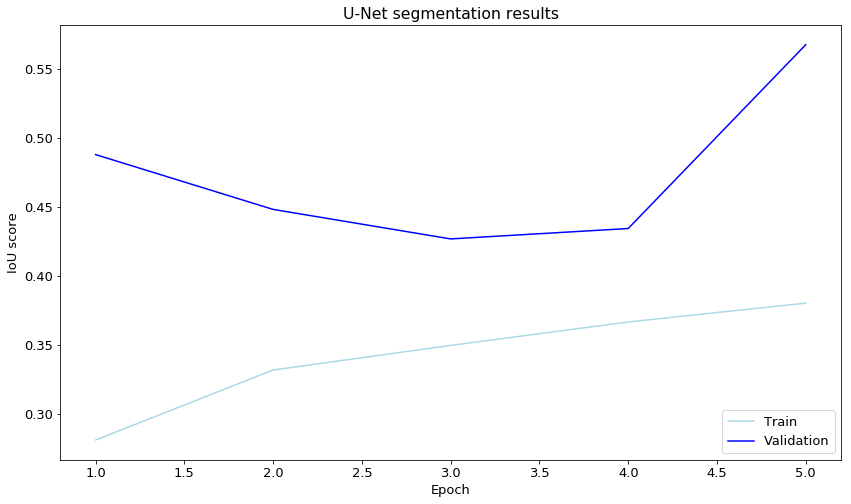

In [167]:
x = range(1,6)
plt.plot(x[:len(results['train'])], results['train'], label='Train', color='lightblue')
plt.plot(x[:len(results['val'])], results['val'], label='Validation', color='blue')
plt.title('U-Net segmentation results')
plt.xlabel('Epoch')
plt.ylabel('IoU score')
plt.legend(loc='lower right')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams.update({'font.size': 13})
plt.show()

In [171]:
# Testing purposes
data = nd.reshape(sample_base, (1,3,img_width,img_height)).as_in_context(ctx)
a = net(data)
a = nd.argmax(a, axis=1)

In [179]:
sample_mask.shape

(1, 256, 256)

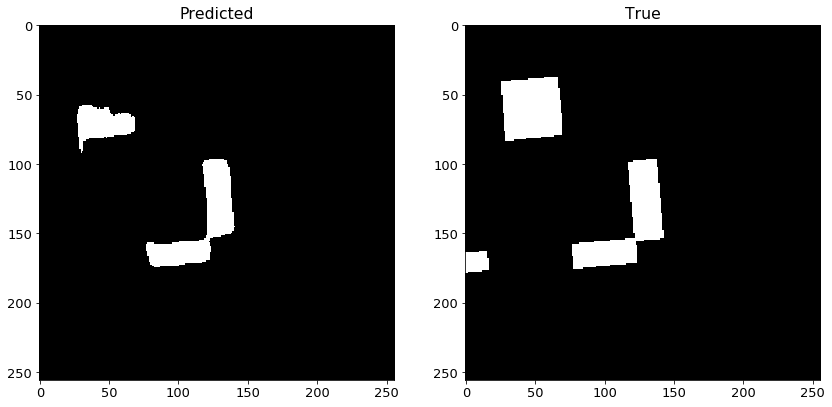

In [181]:
plt.gray()
plt.subplots(figsize=(14, 8))

# Plot prediction
ax1 = plt.subplot(1, 2, 1)
ax1.imshow(a[0].asnumpy())
ax1.set_title("Predicted")

# Plot groud truth
ax2 = plt.subplot(1, 2, 2)
ax2.imshow(sample_mask[0].asnumpy())
ax2.set_title("True")
plt.show()